In [41]:
import pandas as pd
import numpy 
import os
import git
import pickle
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder as le
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [4]:
## Read the labelled files and the poly_user
def get_git_root(path):
	git_repo = git.Repo(path, search_parent_directories=True)
	git_root = git_repo.git.rev_parse("--show-toplevel")
	return git_root

In [5]:
top_dir = os.path.join(get_git_root(os.getcwd()))
df_tweets = pd.read_csv(os.path.join(get_git_root(os.getcwd()),"input","labelled_data","tweets_predicted.csv"), lineterminator="\n", index_col=0)

In [6]:
poly_dir = os.path.join(top_dir,"models","poly_users")
poly_users = pickle.load(open(os.path.join(poly_dir,"poly_users.pkl"),"rb"))
normal_users = pickle.load(open(os.path.join(poly_dir,"normal_users.pkl"),"rb"))

In [7]:
print("total users", len(normal_users))

total users 3177


In [8]:
mono_users = list(set(normal_users) - set(poly_users))

In [9]:
print("total tweets: ",len(df_tweets))
print("total users: ",len(df_tweets.userID.unique()))

total tweets:  111274
total users:  4857


In [10]:
poly_tweets = df_tweets.loc[df_tweets.userID.isin(poly_users)]

In [11]:
mono_tweets = df_tweets.loc[df_tweets.userID.isin(mono_users)]

In [12]:
print("all tweets by poly users: ", len(poly_tweets))
print("poly users (based with retweets):", len(poly_tweets.userID.unique()))

all tweets by poly users:  97565
poly users (based with retweets): 979


In [13]:
print("all tweets by mono users: ", len(mono_tweets))
print("mono users (based with retweets):", len(mono_tweets.userID.unique()))

all tweets by mono users:  8244
mono users (based with retweets): 2198


## Preparing the data

In [14]:
no_tweets = list()
for user in mono_users:
    tweets =(mono_tweets.loc[mono_tweets.userID == user])
    no_tweets.append((user,len(tweets)))
df_user = pd.DataFrame(no_tweets, columns=["userID","len_tweets"])
df_user = df_user.sort_values(by="len_tweets",ascending=True)

In [15]:
users = df_user.userID.unique()
i = 0
users_no = dict()
users_no[0] = 0
## sorted non-decreasing list  
for idx,element in df_user.iterrows():
    if (element["len_tweets"] < (i + 50)):
        users_no[i] += 1 
    else:
        i = i + 50
        users_no[i] = 1

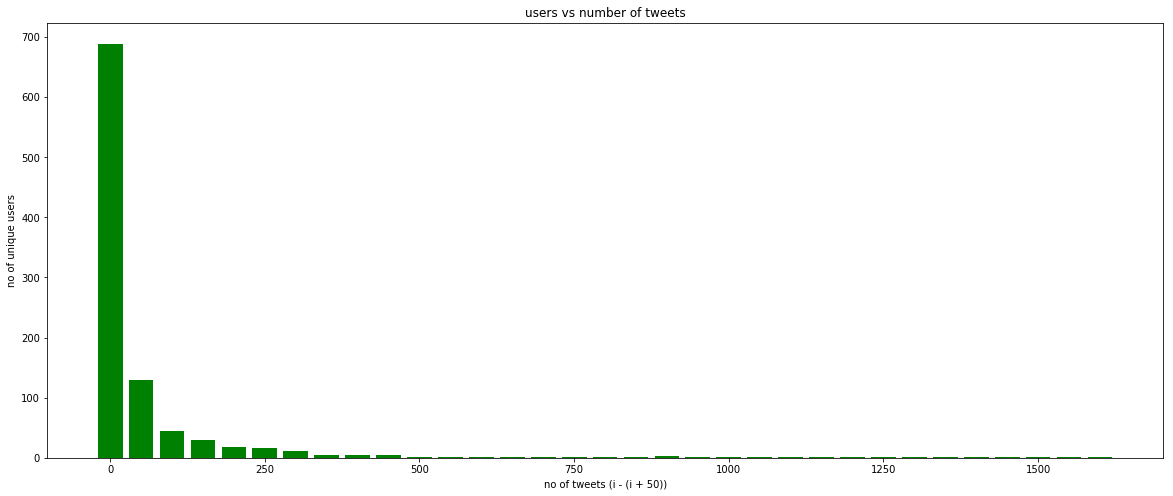

In [242]:
## poly users
plt.figure(figsize= (20,8))
plt.bar(users_no.keys(), users_no.values(), width = 40, color= "green")
plt.xlabel("no of tweets (i - (i + 50))")
plt.ylabel("no of unique users")
plt.title("users vs number of tweets")
plt.show()

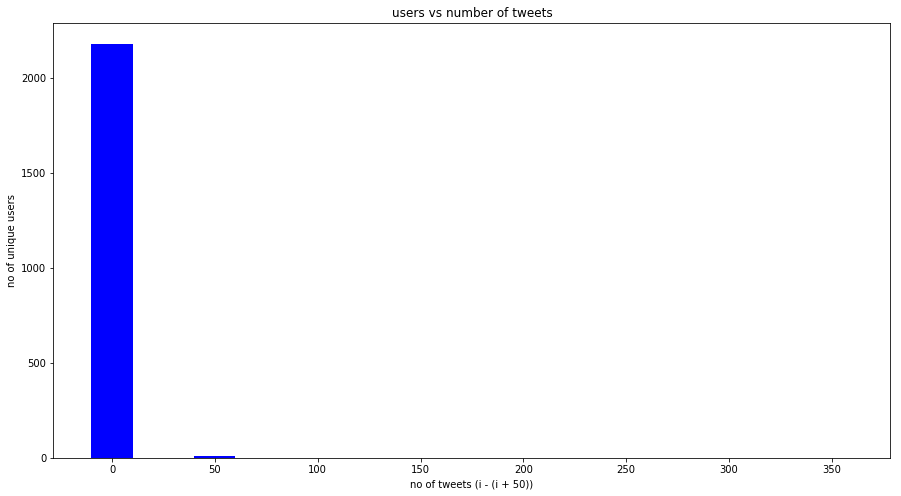

In [249]:
## mono users
plt.figure(figsize= (15,8))
plt.bar(users_no.keys(), users_no.values(), width = 20, color= "blue")
plt.xlabel("no of tweets (i - (i + 50))")
plt.ylabel("no of unique users")
plt.title("users vs number of tweets")
plt.show()

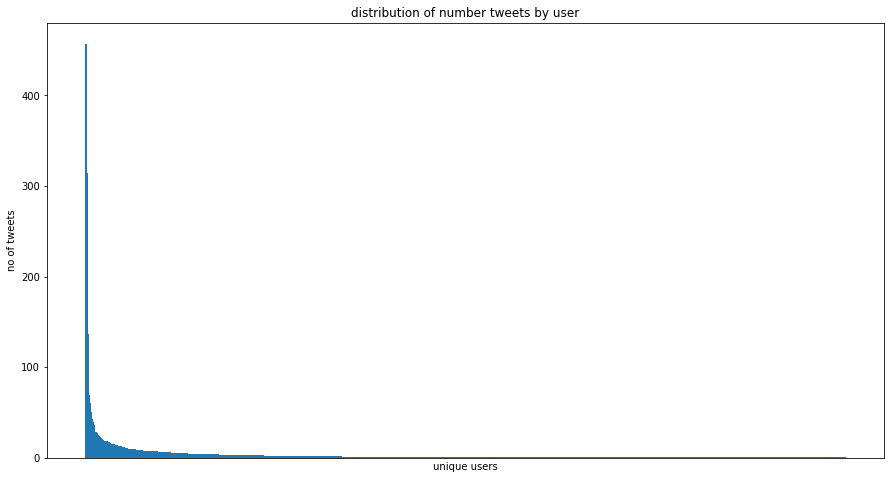

In [194]:
## mono users
plt.figure(figsize=(15,8))
plt.bar([str(user) for user in df_user["userID"]],df_user["len_tweets"],width=5)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    labelbottom=False)
plt.xlabel("unique users", fontsize=10)
plt.ylabel("no of tweets",fontsize=10)
plt.title("distribution of number tweets by user")
plt.show()

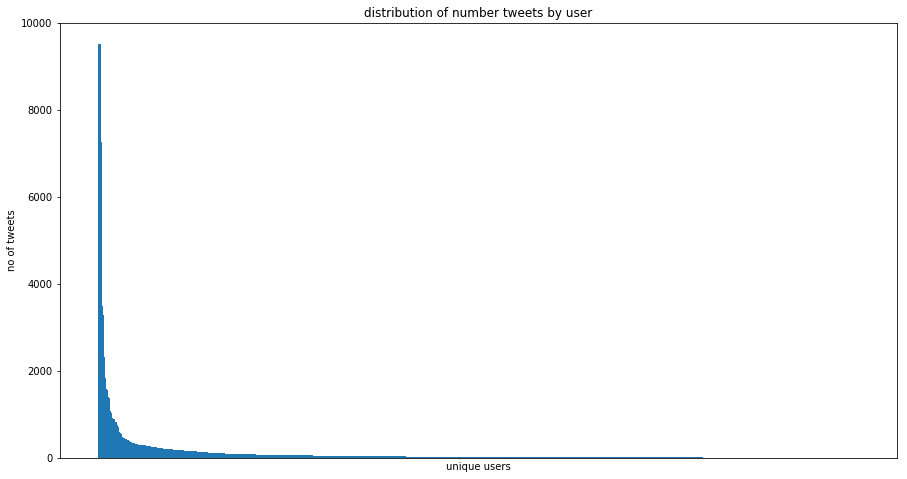

In [59]:
## poly user
plt.figure(figsize=(15,8))
plt.bar([str(user) for user in df_polyt_user["userID"]],df_polyt_user["len_tweets"],width=5)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    labelbottom=False)
plt.xlabel("unique users", fontsize=10)
plt.ylabel("no of tweets",fontsize=10)
plt.title("distribution of number tweets by user")
plt.show()

In [16]:
## cleaning the tweets
import re
def clean_text(text):
    text = re.sub(r'(#)', "",text) ## removing the hashtags signal 
    text = re.sub(r'(RT \w+:)', "",text) ## remove the retweet info as they dont convey any information
    text = re.sub(r'(author)',"",text)
#     text = re.sub(r'')
    text.rstrip
    text.lstrip
    return(text)

## tf-idf vectorizer

In [17]:
import nltk
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/akshayuppal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/akshayuppal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [19]:
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
def get_tokens(sentence):
#     tokens = nltk.word_tokenize(sentence)  # now using tweet tokenizer
    tokens = tknzr.tokenize(sentence)
    tokens = [token.lower() for token in tokens if (token not in stopwords and token.isalpha())] # stopwords removal
    tokens = [get_lemma(token) for token in tokens]  # lemmatization
    return (" ".join(tokens))

Using TensorFlow backend.


In [20]:
## return the tokenized words
def get_token(sentence):
    tokens = tknzr.tokenize(sentence)
    tokens = [token.lower() for token in tokens if (token not in stopwords and token.isalpha())] # stopwords removal
    tokens = [get_lemma(token) for token in tokens]  # lemmatization
    return (tokens)

In [21]:
## cleaning the text
poly_tweets["tweetText"] = poly_tweets["tweetText"].apply(clean_text)
mono_tweets["tweetText"] = mono_tweets["tweetText"].apply(clean_text)

/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
## tokenizing and lemmatizing
poly_tweets["tweetText"] = (poly_tweets["tweetText"].apply(get_tokens))
mono_tweets["tweetText"] = mono_tweets["tweetText"].apply(get_tokens)

/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
## join al the of the tweets for each user
def get_tweets_user(df):
    df_tweets_comb = list()
    users = df.userID.unique()
    for user in users:
        tweets =(df.loc[df.userID == user])
        tweets_f = (" . ".join(tweets["tweetText"]))
        df_tweets_comb.append((user,tweets_f))
    df_user = pd.DataFrame(df_tweets_comb, columns=["userID","tweetText"])
    return (df_user)

In [24]:
poly_tweets_user = get_tweets_user(poly_tweets)
mono_tweets_user = get_tweets_user(mono_tweets)

In [25]:
poly_tweets_user['label'] = "poly"
mono_tweets_user['label'] = "mono"

In [286]:
frames = [poly_tweets_user, mono_tweets_user]
final_tweets = pd.concat(frames)

In [290]:
len(final_tweets)

3177

In [292]:
## tokenize and and get the vocalb
vectorizer = TfidfVectorizer()

In [296]:
vect = vectorizer.fit_transform(final_tweets["tweetText"])

In [294]:
X = (vect.toarray())

In [363]:
le = LabelEncoder()
le.fit(list(final_tweets["label"]))
y = le.transform(list(final_tweets["label"]))

In [366]:
le.classes_

array(['mono', 'poly'], dtype='<U4')

In [367]:
##reduce to lower dimesion
from sklearn.decomposition import PCA
pca = PCA(n_components=100)

In [ ]:
X_new = pca.fit_transform(X)

In [298]:
X.shape

(3177, 50779)

In [325]:
X_new.shape

(3177, 100)

In [340]:
from sklearn.utils import shuffle
X_new, y = shuffle(X_new, y, random_state=4)

In [342]:
## train test split
X_train,X_test,Y_train,Y_test  = train_test_split(X_new, y,test_size =0.20,random_state= 4 )

In [472]:
## Classification
def svm_wrapper(X_train,Y_train):
    param_grid = [
    {'C': [1, 10], 'kernel': ['linear']},
    {'C': [1, 10], 'gamma': [0.1,0.01], 'kernel': ['rbf']},]
    svm1 = GridSearchCV(SVC(),param_grid,verbose=4)
    svm1.fit(X_train, Y_train)
    return(svm1)

In [463]:
X_train.shape

(84647, 100)

In [345]:
svm = svm_wrapper(X_train, Y_train)

/home/samarthgoal/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [370]:
rf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
rf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [377]:
etree = ExtraTreesClassifier(n_estimators=200)
etree.fit(X_train,Y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [380]:
## svm
Y_pred = svm.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

  Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       440
           1       0.95      0.86      0.90       196

   micro avg       0.94      0.94      0.94       636
   macro avg       0.94      0.92      0.93       636
weighted avg       0.94      0.94      0.94       636
 



0.9418238993710691

In [383]:
## random forest
Y_pred = rf.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

  Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.99      0.90       440
           1       0.96      0.53      0.68       196

   micro avg       0.85      0.85      0.85       636
   macro avg       0.89      0.76      0.79       636
weighted avg       0.87      0.85      0.83       636
 



0.8490566037735849

In [384]:
Y_pred = etree.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

  Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       440
           1       0.92      0.80      0.85       196

   micro avg       0.92      0.92      0.92       636
   macro avg       0.92      0.88      0.90       636
weighted avg       0.92      0.92      0.91       636
 



0.9166666666666666

In [397]:
### sentence level ..
poly_tweets["poly_mono"] = "poly"
mono_tweets["poly_mono"] = "mono"

/home/samarthgoal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/samarthgoal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [400]:
frames = [poly_tweets, mono_tweets]
df_final_tweets = pd.concat(frames)

In [403]:
df_final_sentences = df_final_tweets[['tweetText','poly_mono']]

In [405]:
len(df_final_sentences)

105809

In [407]:
## tokenize and and get the vocalb
vect_sentence = TfidfVectorizer()

In [412]:
vect2 = vect_sentence.fit_transform(df_final_sentences["tweetText"])

In [415]:
vect2

<105809x50779 sparse matrix of type '<class 'numpy.float64'>'
	with 1157356 stored elements in Compressed Sparse Row format>

In [418]:
## sentences
count_vect = CountVectorizer()

In [424]:
count_vect.fit(df_final_sentences["tweetText"])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [426]:
print(len(count_vect.vocabulary_))

50779


In [431]:
matrix = count_vect.transform(df_final_sentences["tweetText"])

In [432]:
matrix.shape

(105809, 50779)

In [434]:
matrix[0]

<1x50779 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [437]:
## due to large vocabulary and memory errors using hashing vectorizer
from sklearn.feature_extraction.text import HashingVectorizer
hashing = HashingVectorizer(n_features=100)

In [439]:
vector = hashing.transform(df_final_sentences["tweetText"])

In [441]:
X = vector.toarray()

In [442]:
X.shape

(105809, 100)

In [449]:
le = LabelEncoder()
le.fit(list(df_final_sentences["poly_mono"]))
y = le.transform(list(df_final_sentences["poly_mono"]))

In [451]:
le.classes_

array(['mono', 'poly'], dtype='<U4')

In [456]:
X,y = shuffle(X,y, random_state=5)

In [460]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size =0.20,random_state= 4)

In [470]:
X_train.shape

(84647, 100)

In [ ]:
svm = svm_wrapper(X_train, Y_train)
## svm
Y_pred = svm.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

/home/samarthgoal/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] C=1, kernel=linear ..............................................
[CV] ..... C=1, kernel=linear, score=0.9221009356393536, total= 2.1min
[CV] C=1, kernel=linear ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.2min remaining:    0.0s


[CV] ..... C=1, kernel=linear, score=0.9221009356393536, total= 2.2min
[CV] C=1, kernel=linear ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.4min remaining:    0.0s


[CV] ..... C=1, kernel=linear, score=0.9220981747297536, total= 2.2min
[CV] C=10, kernel=linear .............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.7min remaining:    0.0s


[CV] .... C=10, kernel=linear, score=0.9221009356393536, total= 5.3min
[CV] C=10, kernel=linear .............................................
[CV] .... C=10, kernel=linear, score=0.9221009356393536, total= 5.3min
[CV] C=10, kernel=linear .............................................
[CV] .... C=10, kernel=linear, score=0.9220981747297536, total= 5.2min
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV]  C=1, gamma=0.1, kernel=rbf, score=0.9221009356393536, total=61.4min
[CV] C=1, gamma=0.1, kernel=rbf ......................................


In [ ]:
svm = SVC(C=1,kernel='linear')
## svm
Y_pred = svm.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

In [ ]:
rf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0,verbose=4)
rf.fit(X_train,Y_train,verbose=1)
Y_pred = rf.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

In [ ]:
etree = ExtraTreesClassifier(n_estimators=200,verbose=4)
etree.fit(X_train,Y_train,verbose=1)
Y_pred = etree.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

## get the most common words in the poly and mono tweets

In [26]:
tokens_p = list(poly_tweets_user["tweetText"].apply(get_token))
tokens_j = list(mono_tweets_user["tweetText"].apply(get_token))

In [28]:
## get the list of tokens
## return the most common tokens
from collections import Counter
def build_vocab(tokens_list):
    vocab = Counter()
    for tokens in tokens_list:
        vocab.update(tokens)
    return vocab

In [31]:
## most common words for poly_users tweets
vocab = build_vocab(tokens_p)
vocab.most_common()[:30]

[('tobacco', 37711),
 ('cannabis', 26271),
 ('marijuana', 20531),
 ('weed', 11751),
 ('smoke', 8781),
 ('vape', 8114),
 ('via', 8048),
 ('smoking', 7520),
 ('cigarette', 7330),
 ('vaping', 7029),
 ('cbd', 6612),
 ('new', 5956),
 ('use', 5694),
 ('pot', 5121),
 ('hemp', 4928),
 ('product', 4868),
 ('get', 4394),
 ('health', 4114),
 ('stone', 4077),
 ('tax', 3954),
 ('medical', 3231),
 ('high', 3188),
 ('juul', 2917),
 ('us', 2836),
 ('http', 2629),
 ('big', 2604),
 ('industry', 2600),
 ('ecigs', 2548),
 ('like', 2425),
 ('help', 2375)]

In [32]:
## most common words for juul user tweets
vocab1 = build_vocab(tokens_j)
vocab1.most_common()[:30]

[('juul', 3049),
 ('latest', 1328),
 ('cannabis', 1196),
 ('thanks', 1151),
 ('marijuana', 1139),
 ('smoke', 948),
 ('daily', 942),
 ('tobacco', 894),
 ('vape', 816),
 ('smoking', 739),
 ('vaping', 655),
 ('weed', 520),
 ('fetish', 458),
 ('via', 444),
 ('get', 381),
 ('new', 377),
 ('like', 353),
 ('follow', 330),
 ('cbd', 330),
 ('toker', 315),
 ('pod', 314),
 ('know', 289),
 ('story', 285),
 ('dank', 271),
 ('dope', 268),
 ('turnup', 260),
 ('health', 255),
 ('cali', 251),
 ('use', 251),
 ('life', 246)]

In [33]:
## topic modelling
from gensim import corpora
import pickle
import pyLDAvis.gensim
dictionary = corpora.Dictionary(tokens_p)
corpus = [dictionary.doc2bow(text) for text in tokens_p]
pickle.dump(corpus, open(os.path.join(poly_dir,'corpus.pkl'), 'wb'))
dictionary.save(os.path.join(poly_dir,'dictionary.gensim'))

In [36]:
import gensim
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=8)
ldamodel.save(os.path.join(poly_dir,'model5.gensim'))
topics = ldamodel.print_topics(num_words=4)

/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)


In [37]:
for topic in topics:
    print(topic)

(0, '0.050*"cannabis" + 0.046*"marijuana" + 0.018*"via" + 0.018*"weed"')
(1, '0.044*"cannabis" + 0.027*"weed" + 0.025*"vape" + 0.022*"marijuana"')
(2, '0.074*"tobacco" + 0.012*"use" + 0.011*"smoking" + 0.008*"health"')
(3, '0.068*"tobacco" + 0.023*"cigarette" + 0.020*"vaping" + 0.013*"smoking"')
(4, '0.031*"music" + 0.021*"dope" + 0.015*"hiphop" + 0.013*"new"')


In [43]:
## dont run again
dictionary = gensim.corpora.Dictionary.load(os.path.join(poly_dir,'dictionary.gensim'))
corpus = pickle.load(open(os.path.join(poly_dir,'corpus.pkl'), 'rb'))
lda = gensim.models.ldamodel.LdaModel.load(os.path.join(poly_dir,'model5.gensim'))
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [ ]:
dictionary = corpora.Dictionary(tokens_p)
corpus = [dictionary.doc2bow(text) for text in tokens_j]
pickle.dump(corpus, open(os.path.join(poly_dir,'corpus_m.pkl'), 'wb'))
dictionary.save(os.path.join(poly_dir,'dictionary_m.gensim'))
## LDA
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=8)
ldamodel.save(os.path.join(poly_dir,'model_m.gensim'))
topics = ldamodel.print_topics(num_words=4)

In [40]:
for topic in topics:
    print(topic)

(0, '0.052*"cannabis" + 0.032*"weed" + 0.030*"marijuana" + 0.023*"stone"')
(1, '0.060*"marijuana" + 0.047*"cannabis" + 0.028*"via" + 0.021*"pot"')
(2, '0.079*"tobacco" + 0.015*"cigarette" + 0.013*"smoking" + 0.009*"vaping"')
(3, '0.044*"cannabis" + 0.021*"marijuana" + 0.017*"music" + 0.017*"weed"')
(4, '0.031*"vape" + 0.031*"cbd" + 0.021*"hemp" + 0.016*"smoke"')


In [42]:
## visualizing the mono tweets
## dont run again
dictionary = gensim.corpora.Dictionary.load(os.path.join(poly_dir,'dictionary_m.gensim'))
corpus = pickle.load(open(os.path.join(poly_dir,'corpus_m.pkl'), 'rb'))
lda = gensim.models.ldamodel.LdaModel.load(os.path.join(poly_dir,'model_m.gensim'))
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [ ]:
## mlp at tweet level and user level

### dump the data

In [357]:
## poly_mono_tweet dataset
path= os.path.join(poly_dir,"poly_mono_tweets.csv")
final_tweets.to_csv(path)